In [1]:
import json
import numpy as np
import os
import cv2
import random
import pickle
from tqdm import tqdm
from enum import Enum

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

from keras.models import Sequential, load_model
from keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Activation, \
    Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator, img_to_array
from keras.optimizers import Adam

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

import json
import numpy as np
import os
import cv2
import random
import pickle
from tqdm import tqdm
from enum import Enum

class Shape(Enum):
    Circle = 1
    Semicircle = 2
    Quarter_Circle = 3
    Triangle = 4
    Square = 5
    Rectangle = 6
    Trapezoid = 7
    Pentagon = 8
    Hexagon = 9
    Heptagon = 10
    Octagon = 11
    Star = 12
    Cross = 13



In [2]:
IMAGE_SIZE = 50
img_path = r'..\..\ImageGenerator\Targets'
json_path = r'..\..\ImageGenerator\Target Data'

In [3]:
EPOCHS = 4
INIT_LR = 1e-3
BS = 32
IMAGE_DIMS = (96, 96, 1)

data = []
labels = []
lb = LabelBinarizer()

In [4]:
def create_training_data(image_path, json_path, img_size):
    global data
    global labels
    
    training_data = []
    training_labels = []
    
    
    for img in tqdm(os.listdir(image_path)):
        image = cv2.imread(os.path.join(image_path, img))
        image = cv2.resize(image, (img_size, img_size))
        image = img_to_array(image)
        training_data.append(image)
        
        json_file = img[0:-4] + '.json'
        
        json_dict = json.load(open(os.path.join(json_path, json_file)))
        class_number = Shape[json_dict["shape"]].value
        training_labels.append(class_number)
        
        
    data = np.array(training_data, dtype="float") / 255.0
    labels = np.array(training_labels)
    
    print("[INFO] data matrix: {:.2f}MB".format(data.nbytes / (1024 * 1000.0)))
    
    labels = lb.fit_transform(labels)

In [5]:
def create_model(width, height, depth, classes):
    model = Sequential()
    input_shape = (height, width, depth)
    chan_dim = -1
    if K.image_data_format == "channels_first":
        chan_dim = 1
        
    model.add(Conv2D(32, (3, 3), padding="same", input_shape=input_shape))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chan_dim))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chan_dim))
    model.add(Conv2D(64, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chan_dim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chan_dim))
    model.add(Conv2D(128, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chan_dim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(classes))
    model.add(Activation("softmax"))
    
    return model

In [11]:
def model_training_data():
    (xTrain, xTest, yTrain, yTest) = train_test_split(data, labels, test_size=0.2, random_state=27)
    
    aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1, height_shift_range=0.1, \
                             shear_range=0.2, zoom_range=0.2, fill_mode="nearest")
    
    model = create_model(96,96,3, len(lb.classes_))
    opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
    
    model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
    
    print("TRAINING NETWORK...")
    model.fit(xTrain, yTrain, validation_data=(xTest, yTest), steps_per_epoch=len(xTrain) // BS, \
              epochs=EPOCHS, verbose=1)
    
    print("SAVING MODEL...")
    model.save('shape_classifier.model', save_format="h5")
    f = open(r"../training_data/shape.pickle", "wb")
    f.write(pickle.dumps(lb))
    f.close()

In [24]:
def test_model(imagePath):
    image = cv2.imread(imagePath)
    
    image = cv2.resize(image, (96, 96))
    image = image.astype("float") /  255.0
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    
    model = load_model('shape_classifier.model')
    lb = pickle.loads(open('../training_data/shape.pickle', 'rb').read())
    
    print("Classifying Image...")
    prediction = model.predict(image)[0]
    idx = np.argmax(prediction)
    label = lb.classes_[idx]
    
    print("RESULT: ", end=' ')
    print(prediction)
    print(label)

In [9]:
create_training_data(img_path, json_path, 96)

100%|███████████████████████████████████████████████████████████████████████████| 15000/15000 [00:48<00:00, 311.53it/s]


[INFO] data matrix: 3240.00MB


In [13]:
model_training_data()

TRAINING NETWORK...
Epoch 1/4
375/375 [==============================] - 1274s 3s/step - loss: 0.6583 - accuracy: 0.7866 - val_loss: 39.5633 - val_accuracy: 0.1750
Epoch 2/4
375/375 [==============================] - 1217s 3s/step - loss: 0.0947 - accuracy: 0.9675 - val_loss: 0.1115 - val_accuracy: 0.9673
Epoch 3/4
375/375 [==============================] - 1167s 3s/step - loss: 0.0519 - accuracy: 0.9837 - val_loss: 5.9305 - val_accuracy: 0.8513
Epoch 4/4
375/375 [==============================] - 1259s 3s/step - loss: 0.0213 - accuracy: 0.9949 - val_loss: 0.0662 - val_accuracy: 0.9963
SAVING MODEL...


In [ ]:
print('check')

[0 1 0 0 0 0 0 0 0 0 0 0 0]


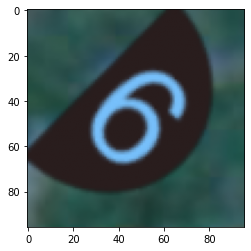

In [14]:
print(labels[2])
import matplotlib.pyplot as plt
plt.imshow(data[2])

Classifying Image...
RESULT:  [1.07176838e-07 9.76498365e-01 1.39889975e-08 2.07508076e-02
 3.63464770e-12 2.59600254e-03 8.06186620e-08 1.08941342e-04
 5.46846124e-09 2.18010072e-07 4.53968387e-05 4.38036949e-08
 1.94840215e-08]
2


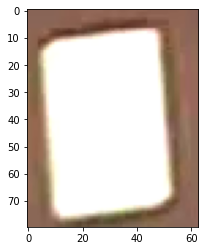

In [25]:
test_model('../foamie_test_frames/hexagon.png')
plt.imshow(cv2.imread('../foamie_test_frames/rect.png'))